## Tutorial - Sampling sparse logistic regression

Author: Shidi Zhao (zhao5@fb.com)

The purpose of this tutorial is to showcase how to write a sparse logistic regression model in Bean Machine and present some inference methods that Bean Machine provides to sample this model.

## Problem

Logistic Regression is a very commonly used statistical method that allows us to predict a binary output from a set of independent variables. Suppose we have some prior knowledge about the data generated from the logistic regression model, we can sample the logistic regression model from the prior. The sparse logistic regression is a type of logistic regression model, it embeds feature selection in the classification by adding overall and pre-dimension scale factors, and has many applications in high-dimensional data, such as classifying credit score. So here, to sample the sparse logistic regression in Bean Machine, we first implement the sparse logistic regression model in Bean Machine and then try to sample it with various inference methods.

## Sparse logistic regression

Sparse logistic regression is a hierarchical logistic regression with a sparse prior $\tau$. We consider the model as following:

   $$
\begin{array}{lcl}
\tau {\sim} Gamma(\alpha = 0.5, \beta = 0.5) \\
\lambda_d{\sim} Gamma(\alpha = 0.5, \beta = 0.5) \\
\beta_d{\sim} Normal(0,1) \\
y_n{\sim}Bernoulli(\sigma{X}^T(\tau\beta \circ \lambda)) \\
\end{array}
$$

Here $\tau$ is the global shrinkage, $\lambda$ is local shrinkage,$\beta \circ \lambda$ denotes the elementwise product of $\beta$ and $\lambda$.

## Prerequisites

Please import the following code packages for the rest of the code in the tutorial to work.

In [1110]:
import torch
import numpy as np
import beanmachine.ppl as bm
from torch.distributions import *
import torch.nn as nn
from beanmachine.ppl.diagnostics.common_statistics import effective_sample_size, split_r_hat,r_hat
from beanmachine.ppl.inference.abstract_infer import (
    VerboseLevel,
)
from torch import tensor,manual_seed, arange, float32, zeros, ones, randn
import matplotlib.pyplot as plt

## Data generation 

To get the prior knowledge about the model, we can generate some data (x,y) use a pre-defined sparse logistic regression model with generated $\tau$-value, $\lambda$-value, and $\beta$-value. Then we split the data into training data(50%) and testing data(50%). For the training data, we are going to run inference on it, and for the testing data, we are going to compute the predictive log-likelihood.

In [1117]:
manual_seed(38)

D=3 #number of predictors
N=100 #number of observations

tau_value = Gamma(tensor(0.5),tensor(0.5)).sample()
lambda_value = Gamma(0.5,0.5).sample(sample_shape=(D,1))
beta_value = Normal(0,1).sample(sample_shape=(D,1))
X = Normal(0,10).sample(sample_shape=(N,D)) 
mu = X.mm(torch.mul(tau_value*beta_value,lambda_value))
Y= Bernoulli(logits=mu).sample()

In [1118]:
train_size=test_size= int(N/2)

TRAIN_DATA_X = X[:train_size]
TEST_DATA_X = X[test_size:]
TRAIN_DATA_Y = Y[:train_size]
TEST_DATA_Y = Y[test_size:]

## Model

To implement sparse logistic regression model in Bean Machine, we have random variable $\tau$(), $\lambda$(), $\beta$() and y(). Here, we sample the random variables using MCMC, the observation here is the training data. Then we compute the predictive log-likelihood using test data. The predictive log-likelihood has an important role in statistical model comparison, the highest predictive log-likelihood will have the highest posterior probability, thus it can measure how the model fits overall.

In [1131]:
class Sparse(object):
    def __init__(self,num_predictors,train_x,test_x,test_y):
        self.D = num_predictors
        self.TRAIN_DATA_X = train_x
        self.TEST_DATA_X=test_x
        self.TEST_DATA_Y=test_y
        
    @bm.random_variable
    def tau(self):
        return Gamma(tensor(0.5), tensor(0.5))

    @bm.random_variable
    def lambda_(self):
        return Gamma(tensor([[0.5]] * (self.D)), tensor([[0.5]] * (self.D)))

    @bm.random_variable
    def beta(self):
        return Normal(zeros((self.D, 1)), ones((self.D, 1)))

    @bm.random_variable
    def y(self):
        y_=self.TRAIN_DATA_X.mm(torch.mul(self.tau()*self.beta(),self.lambda_()))
        return Bernoulli(logits=y_)

    @bm.functional
    def log_prob_test(self):
        y = self.TEST_DATA_X.mm(torch.mul(self.tau()*self.beta(),self.lambda_()))
        s =(Bernoulli(logits=y)).log_prob(self.TEST_DATA_Y).sum()
        return s

## Inference

Now, we will go through the performance of different inference methods on this model. We will investigate different inference algorithms, single-site Hamiltonian Monte Carlo (HMC), single-site MetropolisHastings, and single-site Newtonian Monte Carlo (NMC)

### Single-site NMC

In [1132]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
dict_y = {s.y(): TRAIN_DATA_Y}
nw = bm.SingleSiteNewtonianMonteCarlo()
samples_nw = nw.infer([s.log_prob_test(),s.tau(),s.lambda_(),s.beta()], dict_y , 10, 3,verbose=VerboseLevel.OFF)

In [1133]:
post_nw = tensor(samples_nw[s.log_prob_test()])

## Analysis¶

Here, we compare the mean value of tao, lambda and beat with the generated $\tau$-value, $\lambda$-value, and $\beta$-value, and compute the effective sample size and r hat of the samples as well.

In [1134]:
def analysis(label,samples, model_tao,model_lambda,model_beta,D):
    
    Tau = samples[model_tao].detach()
    Lambda = samples[model_lambda].detach()
    Beta=samples[model_beta].detach()
    
    print("for "+label+":")
    print("Predicted Tao mean:", round(samples[model_tao].mean().item(), 3), "vs Tau that data was generated with:", round(tau_value.mean().item(), 3))
    print("Predicted Lambda mean:", round(samples[model_lambda].mean().item(), 3), "vs Lambda that data was generated with:", round(lambda_value.mean().item(), 3))
    print("Predicted Tao mean:", round(samples[model_beta].mean().item(), 3), "vs Beta that data was generated with:", round(beta_value.mean().item(), 3))
    
    print("effective sample size", effective_sample_size(Tau),", r hat", split_r_hat(Tau))
    print("effective sample size", effective_sample_size(Lambda).view(1,D),", r hat", split_r_hat(Lambda).view(1,D))
    print("effective sample size", effective_sample_size(Beta).view(1,D),", r hat", split_r_hat(Beta).view(1,D))

In [1135]:
analysis("Single-site NMC",samples_nw,s.tau(),s.lambda_(),s.beta(),D)

for Single-site NMC:
Predicted Tao mean: 3.864 vs Tau that data was generated with: 1.136
Predicted Lambda mean: 0.935 vs Lambda that data was generated with: 0.15
Predicted Tao mean: -0.073 vs Beta that data was generated with: -1.044
effective sample size tensor(3.6529) , r hat tensor(1.7423)
effective sample size tensor([[1.8104, 1.8104, 1.8104]]) , r hat tensor([[2.7203, 2.7203, 2.7203]])
effective sample size tensor([[2.5923, 4.0948, 3.7746]]) , r hat tensor([[1.5838, 1.5343, 1.3231]])


From the analysis, we can see the lambda would get stuck with half-space proposer in NMC. Since it is in half-space, so it initializes the value with 1. We can see from the mean value of $\lambda$, it does not move. And we try with the current real space proposer, the acceptance is 5% for 100 samples. We would continue working on this model with the latest NMC inference method.

### Single-site MetropolisHastings

In [1124]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
mh = bm.SingleSiteAncestralMetropolisHastings()
samples_mh = mh.infer([s.log_prob_test(),s.tau(),s.lambda_(),s.beta()], dict_y, 10, 3,verbose=VerboseLevel.OFF)

In [1125]:
post_mh = tensor(samples_mh[s.log_prob_test()])

In [1126]:
analysis("Single-site MH",samples_mh,s.tau(),s.lambda_(),s.beta(),D)

for Single-site MH:
Predicted Tao mean: 1.336 vs Tau that data was generated with: 1.136
Predicted Lambda mean: 0.863 vs Lambda that data was generated with: 0.15
Predicted Tao mean: 0.015 vs Beta that data was generated with: -1.044
effective sample size tensor(134.0233) , r hat tensor(0.9615)
effective sample size tensor([[28.8424, 42.0718, 17.6982]]) , r hat tensor([[0.9506, 0.9850, 0.9781]])
effective sample size tensor([[10.3614, 43.0382, 25.2414]]) , r hat tensor([[1.1139, 0.9914, 1.0146]])


### Single-site HMC

In [1127]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
step_size = 0.5
num_steps=1
hmc = bm.SingleSiteHamiltonianMonteCarlo(step_size, num_steps)
samples_hmc = mh.infer([s.log_prob_test(),s.tau(),s.lambda_(),s.beta()], dict_y , 10, 3,verbose=VerboseLevel.OFF)

In [1128]:
analysis("Single-site HMC",samples_hmc,s.tau(),s.lambda_(),s.beta(),D)

for Single-site HMC:
Predicted Tao mean: 1.0 vs Tau that data was generated with: 1.136
Predicted Lambda mean: 1.0 vs Lambda that data was generated with: 0.15
Predicted Tao mean: 0.0 vs Beta that data was generated with: -1.044
effective sample size tensor(nan) , r hat tensor(nan)
effective sample size tensor([[nan, nan, nan]]) , r hat tensor([[nan, nan, nan]])
effective sample size tensor([[nan, nan, nan]]) , r hat tensor([[nan, nan, nan]])


In [1129]:
post_hmc = tensor(samples_hmc[s.log_prob_test()])

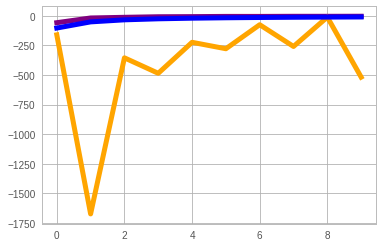

In [1130]:
p_nw=post_nw.cumsum(dim=0) / arange(1, len(post_mh[0])+1)
p_mh=post_mh.cumsum(dim=0)/ arange(1, len(post_mh[0])+1)
p_hmc=post_hmc.cumsum(dim=0) / arange(1, len(post_hmc[0])+1)

plt.plot(p_nw[-1],color="purple",linewidth=5)
plt.plot(p_mh[-1],color="orange",linewidth=5)
plt.plot(p_hmc[-1],color="blue",linewidth=5)

## German-numeric data

Next, we consider our sparse logistic regression model with German credit dataset, you can download the data from: https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric. 
We use the numeric variant of the german credit dataset, with the covariates standardized to range between -1 and 1. With the addition of a constant factor, this yields 25 covariates (the data preprocess is the same as [NeuTra](https://arxiv.org/pdf/1903.03704.pdf) paper.

In [1136]:
data = np.genfromtxt("german.data-numeric")
x = data[:, :-1]
y = (data[:, -1] - 1)
x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)
x /= (x_max - x_min)
x = 2.0 * x - 1.0
x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)
x =[torch.from_numpy(x[i]) for i in range(1000)]
y = torch.from_numpy(y).view(len(x),1)
D,N=len(x[0]),len(x)

Since we only want to use all the data to train the model, we do not have test data as the previous case. here in the input, test data is the same as training data, which is the whole data set. And we use log_prob_test() to compute the predictive log-likelihood of training data.

In [1137]:
TRAIN_DATA_X = torch.stack(x).float()
TEST_DATA_X = torch.stack(x).float()
TRAIN_DATA_Y = y
TEST_DATA_Y=y

In [1140]:
s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)

In [1141]:
dict_y = {s.y(): TRAIN_DATA_Y}

s = Sparse(D,TRAIN_DATA_X,TEST_DATA_X,TEST_DATA_Y)
nw = bm.SingleSiteNewtonianMonteCarlo()
samples_nw = nw.infer([s.tau(),s.lambda_(),s.beta()], dict_y , 10, 3,verbose=VerboseLevel.OFF)

In [1142]:
analysis("Single-site NMC",samples_nw,s.tau(),s.lambda_(),s.beta(),D)

for Single-site NMC:
Predicted Tao mean: 1.027 vs Tau that data was generated with: 1.136
Predicted Lambda mean: 1.0 vs Lambda that data was generated with: 0.15
Predicted Tao mean: -0.001 vs Beta that data was generated with: -1.044
effective sample size tensor(34.3803) , r hat tensor(0.9936)
effective sample size tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan]]) , r hat tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan]])
effective sample size tensor([[  16.1713,   18.6361,    7.0798,   21.5570,   21.0521, 2130.0254,
           12.0979,    9.0913,   46.4759,   37.1142,   19.3713,   32.6580,
           26.6086,   26.8423,   22.4751,   19.2516,   26.7237,   18.2936,
           20.5685,   14.2885,    5.5679,   20.7948,    9.6529,   15.3659,
           21.5948]]) , r hat tensor([[1.1251, 1.1507, 1.2530, 